In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ENSEMBLE_MEMBERS = 3

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [4]:
CLASS_NAMES = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [18]:
def build_and_compile_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same',
                             activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPool2D(strides=2),
      tf.keras.layers.Conv2D(filters=48, kernel_size=(5,5), padding='valid',
                             activation='relu'),
      tf.keras.layers.MaxPool2D(strides=2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(84, activation='relu'),
      tf.keras.layers.Dense(10)
  ])
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [19]:
deep_ensemble = []
for ind in range(ENSEMBLE_MEMBERS):
  model = build_and_compile_model()
  print(f"Train model {ind:02}")
  model.fit(train_images, train_labels, epochs=10) 
  deep_ensemble.append(model)

Train model 00
Epoch 1/10
1875/1875 [==============================] - 95s 50ms/step - loss: 0.5533 - accuracy: 0.8400
Epoch 2/10
1875/1875 [==============================] - 94s 50ms/step - loss: 0.3177 - accuracy: 0.8835
Epoch 3/10
1875/1875 [==============================] - 94s 50ms/step - loss: 0.2847 - accuracy: 0.8954
Epoch 4/10
1875/1875 [==============================] - 95s 51ms/step - loss: 0.2644 - accuracy: 0.9026
Epoch 5/10
1875/1875 [==============================] - 95s 51ms/step - loss: 0.2426 - accuracy: 0.9110
Epoch 6/10
1875/1875 [==============================] - 96s 51ms/step - loss: 0.2275 - accuracy: 0.9163
Epoch 7/10
1875/1875 [==============================] - 96s 51ms/step - loss: 0.2157 - accuracy: 0.9204
Epoch 8/10
1875/1875 [==============================] - 96s 51ms/step - loss: 0.1992 - accuracy: 0.9258
Epoch 9/10
1875/1875 [==============================] - 97s 52ms/step - loss: 0.1913 - accuracy: 0.9293
Epoch 10/10
1875/1875 [==========================

In [20]:
# get logit predictions for all three models for images in the test split
ensemble_logit_predictions = [model(test_images) for model in deep_ensemble]
# convert logit predictions to softmax
ensemble_softmax_predictions = [tf.nn.softmax(logits, axis=-1) for logits in ensemble_logit_predictions]
# take the mean across the three models, this will result in one softmax prediction vector per image
ensemble_predictions = tf.reduce_mean(ensemble_softmax_predictions, axis=0)

In [21]:
# calculate variance across model predictions
ensemble_std = tf.reduce_mean(
    tf.math.reduce_variance(ensemble_softmax_predictions, axis=0),
    axis=1)
# find index of test image with highest variance across predictions
ind_disagreement = np.argmax(ensemble_std)

# get predictions per model for test image with highest variance
ensemble_disagreement = []
for ind in range(ENSEMBLE_MEMBERS):
  model_prediction = np.argmax(ensemble_softmax_predictions[ind][ind_disagreement])
  ensemble_disagreement.append(model_prediction)
# get class predictions
predicted_classes = [CLASS_NAMES[ind] for ind in ensemble_disagreement]

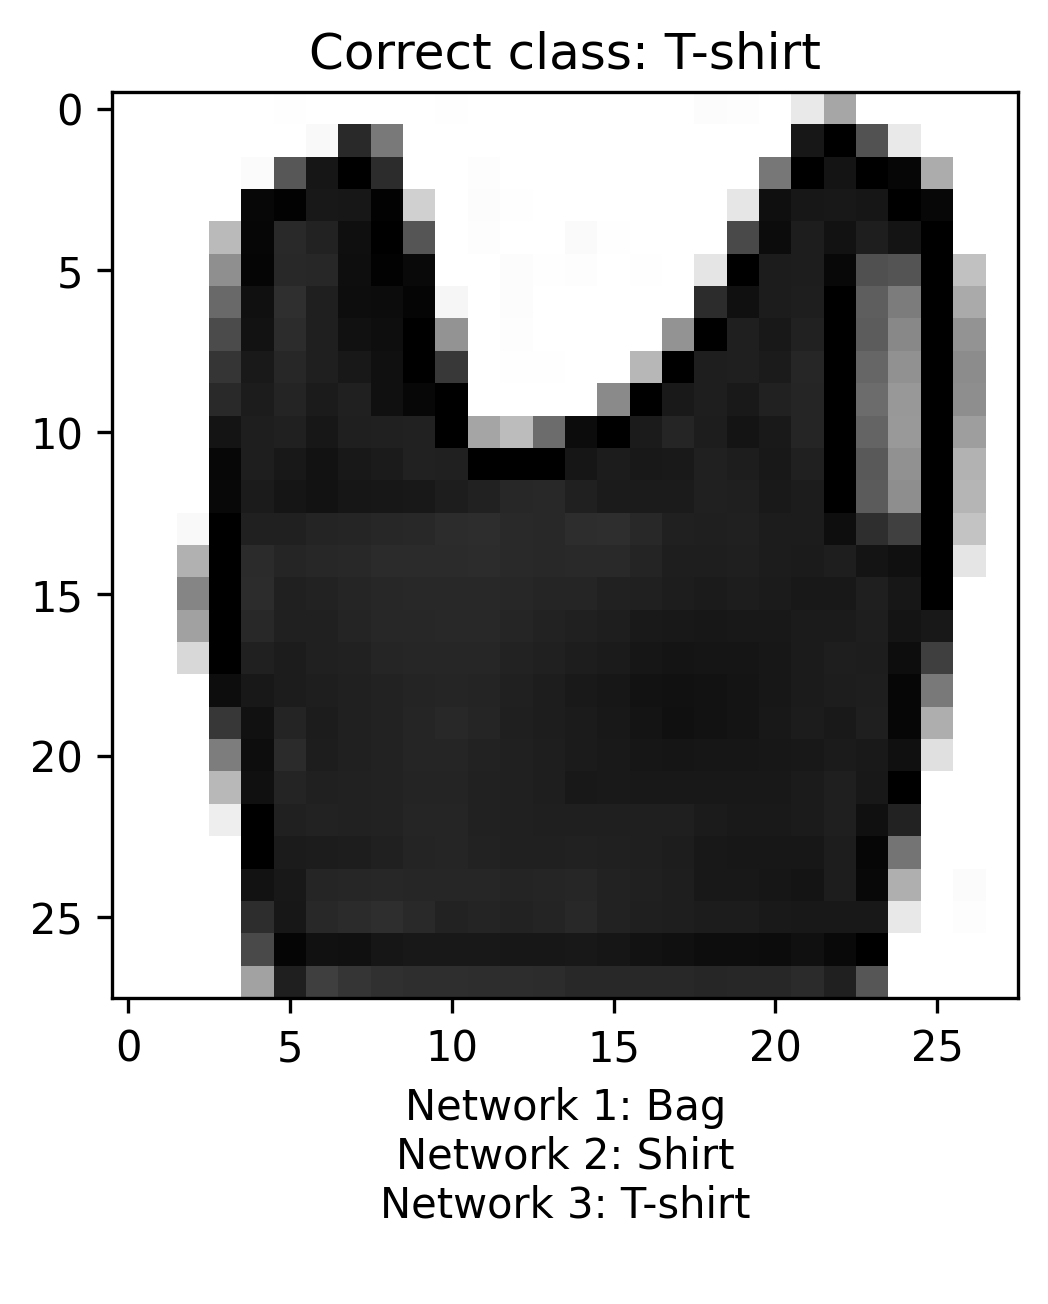

In [22]:
# define image caption
image_caption = \
  f"Network 1: {predicted_classes[0]}\n" + \
  f"Network 2: {predicted_classes[1]}\n" + \
  f"Network 3: {predicted_classes[2]}\n"
# visualise image and predictions
plt.figure(dpi=300)
plt.title(f"Correct class: {CLASS_NAMES[test_labels[ind_disagreement]]}")
plt.imshow(test_images[ind_disagreement], cmap=plt.cm.binary)
plt.xlabel(image_caption)
plt.show()